In [1]:
import os
import re
import json
import matplotlib.pyplot as plt
import numpy as np
import string
import pandas as pd
import pyspark.sql.functions as F


from itertools import chain
from scipy.sparse import coo_matrix
from pyspark.mllib.linalg.distributed import CoordinateMatrix, MatrixEntry, IndexedRow, IndexedRowMatrix
from pyspark.sql import Row
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifierCV
from operator import add
from pyspark.sql.functions import udf
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, FloatType
from __future__ import print_function, unicode_literals, with_statement, absolute_import, generators, nested_scopes, division
from pyspark.sql.functions import mean, stddev
%matplotlib inline 

In [2]:
# Local Spark
# spark session is now the entry point of spark program
# for line 8, can use local[n] for run spark locally with n cores
spark = SparkSession.builder \
    .master('local[10]') \
    .appName('Spark Try') \
    .getOrCreate()
    

In [3]:
data = spark.read.json('/project/cmsc25025/beer_review/labeled.json').dropna()
data.show(5)

+----------+-----+-------+--------------------+------+-------+------+--------------------+---------+-----+-----+
|appearance|aroma|beer_id|           beer_name|brewer|overall|palate|              review|review_id|style|taste|
+----------+-----+-------+--------------------+------+-------+------+--------------------+---------+-----+-----+
|       4.0|  6.0|  45842|John Harvards Sim...|  3084|   13.0|   3.0|On tap at the Spr...|        0|   17|  6.0|
|       4.0|  6.0|  45842|John Harvards Sim...|  3084|   13.0|   4.0|On tap at the Joh...|        1|   17|  7.0|
|       4.0|  5.0|  95213|John Harvards Cri...|  3084|   14.0|   3.0|UPDATED: FEB 19, ...|        2|   33|  6.0|
|       2.0|  4.0|  65957|John Harvards Fan...|  3084|    8.0|   2.0|On tap the Spring...|        3|   33|  4.0|
|       5.0|  8.0|  41336|John Harvards Van...|  3084|   16.0|   4.0|Springfield, PA l...|        5|   58|  7.0|
+----------+-----+-------+--------------------+------+-------+------+--------------------+------

# Part 1: Data inspection
check the mean, median and standard deviation of the overall ratings for each beer and brewer. Do you think people have similar taste?

In [19]:
#data.select('overall').describe().show()

In [20]:
def find_median(values_list):
    try:
        median = np.median(values_list) #get the median of values in a list in each row
        return round(float(median),2)
    except Exception:
        return None #if there is anything wrong with the given values

median_finder = udf(find_median,FloatType())

In [44]:
df_a = data.groupBy('beer_name').agg({'overall': 'stddev'}).toPandas()
df_b = data.groupBy('beer_name').agg({'overall': 'mean'}).toPandas()
df_c = data.groupBy('beer_name').agg(F.collect_list('overall').alias('m')).withColumn("median",median_finder("m")).toPandas()
df_c = df_c.iloc[:,[0,2]].set_index('beer_name')

df_beer = df_a.set_index('beer_name').join(df_b.set_index('beer_name')).join(df_c).sort_values(by = 'stddev(overall)', ascending = False)
df_beer

,stddev(overall),avg(overall),median
beer_name,,,
Mountain Town Ultra Lite,12.727922,11.000000,11.0
Left Hand Bourbon Barrel Milk Stout,11.313708,10.000000,10.0
Four Peaks Barrel-Aged Blind Date Ale,11.313708,9.000000,9.0
Berliner Kindl Weisse Tropical,11.313708,12.000000,12.0
Lovejoys Folsom Prison Blueberry Porter,11.313708,10.000000,10.0
Samuel Adams Bitter,10.606602,12.500000,12.5
LCL Pils &#40;Draught&#41;,10.606602,12.500000,12.5
John S. Rhodell Cherry Dark Ale,10.606602,9.500000,9.5
Molson Carling Extreme,10.606602,10.500000,10.5


In [45]:
df_d = data.groupBy('brewer').agg({'overall': 'stddev'}).toPandas()
df_e = data.groupBy('brewer').agg({'overall': 'mean'}).toPandas()

df_f = data.groupBy('brewer').agg(F.collect_list('overall').alias('m')).withColumn("median",median_finder("m")).toPandas()
df_f = df_f.iloc[:,[0,2]].set_index('brewer')

df_brewer = df_d.set_index('brewer').join(df_e.set_index('brewer')).join(df_f).sort_values(by = 'stddev(overall)', ascending = False)
df_brewer

,stddev(overall),avg(overall),median
brewer,,,
5012,9.899495,13.000000,13.0
7132,9.192388,7.500000,7.5
5580,8.962886,9.666667,5.0
7373,8.906926,10.000000,9.0
3448,8.485281,8.000000,8.0
3018,8.485281,7.000000,7.0
706,8.082904,12.666667,14.0
7250,8.082904,12.333333,17.0
6766,7.847505,8.250000,8.0


Generally speaking, people have pretty different opinions because the standard deviations are very high; however, we do observe that medians are generally very close to the mean. This might sugguest that there are big differences on both sides of the mean. In other words, for each beer/brewer, some people have extremely positive opinons (compared to the mean) and others have extremely negative opinions. 

Comparing the opinion distribution between beer and brewer, we observe that people have more similar view for the brewers than beers since the standard deviations of brewers are generall less than those of beers.

# Part 2: Sentiment analysis
(1) Generating features

In [4]:
with open('/project/cmsc25025/beer_review/vocab_50.json', 'r') as f:
         vocab_dict = json.load(f)
vocab = vocab_dict.keys()
vocab = map(lambda x: str(x), vocab)
num_doc = data.count()
num_f = len(vocab)

In [5]:
def trans(t):
    return t.lower().encode('utf-8').translate(string.maketrans("",""), string.punctuation).strip().split()

def get_sent(s):
    if s>=14:
        return 1
    else:
        return 0

def get_counts(l):
    res = []
    for word in vocab:
        res.append(l.count(word))
    res_mat = coo_matrix(np.array(res))
    return res_mat

In [6]:
transRDD = data.rdd.map(lambda x:( trans(x['review']), get_sent(x['overall']))).cache()

In [7]:
train_t, vali_t, test_t = transRDD.randomSplit([0.7, 0.15, 0.15], 1234)

In [8]:
trainRDD = train_t.map(lambda x: (get_counts(x[0]),x[1])).cache()
valiRDD = vali_t.map(lambda x: (get_counts(x[0]),x[1])).cache()
testRDD = test_t.map(lambda x: (get_counts(x[0]),x[1])).cache()

In [9]:
#X_test_t = coo_matrix(np.array(testRDD.map(lambda x: x[0]).collect()))
#y_test_t = coo_matrix(np.array(testRDD.map(lambda x: x[1]).collect()))

In [ ]:
X_test_t = coo_matrix(testRDD.map(lambda x: x[0]).reduce(lambda x,y: np.vstack(x,y)))

In [ ]:
y_test_t = np.array(testRDD.map(lambda x: x[1]).collect())

In [12]:
#testRDD.map(lambda x: x[0]).toDF().take(1)

(2)SGD

plot the error rate and negative log-likelihood for both training and validation set as a function of iterations

In [ ]:
def update_beta(beta, x, y, lr, lam):

    pi = 1/(1+np.exp(-x.dot(beta)))
    beta_1 = beta+lr*(np.dot((y-pi), x)-lam)
    return beta_1

def sgd_log(train_t, epoch_num, maxiter):
    lr = 1/maxiter
    beta = np.zeros(num_f)
    for i in range(epoch_num):
        batches = train_t.randomSplit([1] * maxiter)
        lams = [0.03, 0.05, 0.08, 0.1, 0.12, 0.15]
        betas = []
        
        for lam in lams:
            for batch in batches:
                X_mat = coo_matrix(batch.map(lambda x: x[0]).reduce(lambda x,y: np.vstack(x,y)))
                y = np.array(batch.map(lambda x: x[1]).collect())

                beta = update_beta(beta, X_mat, y, lr, lam)
                beta = (beta-np.mean(beta))/np.std(beta)
            betas.append(beta)
    return betas

def get_mse(beta,X, y):
    num = y.shape[0]
    diff = y - 1/(1+np.exp(-X.dot(beta)))
    mse = np.dot(diff.T, diff)/num
    return mse

def validate (vali_t, betas):
    X_vali = coo_matrix(vali_t.map(lambda x: x[0]).reduce(lambda x,y: np.vstack(x,y)))
    y_vali = np.array(vali_t.map(lambda x: x[1]).collect())
    
    min_error = 0
    for beta in betas:
        mse = get_mse(beta, X_vali, y_vali)
        if mse < min_error:
            min_error = mse
            beta_op = beta
    return (beta, min_error)

def cal_nll(row):
    x = np.array(row[0])
    y = np.array(row[1])
    return y*(x.dot(beta))-np.log(1+np.exp(x.dot(beta)))

def get_nll(beta, vali_t):
    return -vali_t.rdd.map(lambda x: cal_nll(x)).reduce(add)

In [ ]:
iter_nums = [1, 20, 40]
vali_errors = []
vali_nlls = []

test_errors = []
test_nlls = []

for i in iter_nums:
    betas = sgd_log(train_t, 1, i)
    beta, vali_error = validate(vali_t, betas)
    test_error = get_mse(beta, X_test_t, y_test_t)
    vali_nll = get_nll(beta, vali_t)
    test_nll = get_nll(beta, test_t)
    
    vali_errors.append(vali_error)
    vali_nlls.append(vali_nll)
    test_errors.append(test_error)
    test_nlls.append(test_nll)

In [ ]:
fig, ax = plt.subplots()
ax.plot(iter_nums, test_errors, '--', color = 'r')
ax.plot(iter_nums, vali_errors, '--', color = 'g')

ax.set_ylabel('Mean squared error')
ax.set_xlabel('Number of iterations')
ax.set_title("MSE vs. number of iterations")
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(iter_nums, test_nlls, '--', color = 'r')
ax.plot(iter_nums, vali_nlls, '--', color = 'g')

ax.set_ylabel('Negative Log likelihood')
ax.set_xlabel('Number of iterations')
ax.set_title('NLL vs. number of iterations')
plt.show()

In [ ]:
#codes to generate tfidf, but it's too slow

# def df(l):
#     res = []
#     for word in vocab:
#         if word in l:
#             res.append((word, 1))
#         else:
#             res.append((word, 0))
#     return res

# def tf_and_df(x):
#     #y = x[0]
#     l = x[0]
#     res = []
#     for word in vocab:
#         c = l.count(word)
#         doc_f = dfdic[word]
#         tfidf = c*np.log(num_doc/doc_f)
#         #res.append([y,word, tfidf])
#         res.append(tfidf)
#     return res

# #get df
# dflist = transRDD.flatMap(lambda x: df(x[0])).reduceByKey(add).collect()
# dfdic = dict(dflist)

# tfidfRDD = transRDD.map(lambda x: (tf_and_df(x), x[1])).cache()

In [ ]:
# from pyspark.mllib.linalg.distributed import CoordinateMatrix, MatrixEntry, IndexedRow, IndexedRowMatrix
# #mat = IndexedRowMatrix(trainRDD.map(lambda row: IndexedRow(*row)))
# mat = CoordinateMatrix(trainRDD.map(lambda row: MatrixEntry(*row)))



# Part 3: Scores versus text

In [54]:
#getting features 
sRDD = data.rdd.map(lambda x:(x['appearance'],x['aroma'],x['palate'],x['style'], x['taste'], get_sent(x['overall']))).cache()
train_s, vali_s, test_s = sRDD.toDF().randomSplit([0.7, 0.15, 0.15], 1234)

X_test = np.array(test_s.rdd.map(lambda x: x[0:5]).collect())
y_test = np.array(test_s.rdd.map(lambda x: x[-1]).collect())

In [60]:
def update_beta(beta, x, y, lr, lam):

    pi = 1/(1+np.exp(-x.dot(beta)))
    beta_1 = beta+lr*(np.dot((y-pi), x)-lam)
    return beta_1

def sgd_log(train_s, epoch_num, maxiter):
    lr = 1/maxiter
    beta = np.zeros(5)
    for i in range(epoch_num):
        batches = train_s.rdd.randomSplit([1] * maxiter)
        lams = [0.03, 0.05, 0.08, 0.1, 0.12, 0.15]
        betas = []
        
        for lam in lams:
            for batch in batches:
                X_mat = np.array(batch.map(lambda x: x[0:5]).collect())
                y = np.array(batch.map(lambda x: x[-1]).collect())

                beta = update_beta(beta, X_mat, y, lr, lam)
                beta = (beta-np.mean(beta))/np.std(beta)
            betas.append(beta)
    return betas

def get_mse(beta,X, y):
    num = y.shape[0]
    diff = y - 1/(1+np.exp(-X.dot(beta)))
    mse = np.dot(diff.T, diff)/num
    return mse

def validate (vali_s, betas):
    X_vali = np.array(vali_s.rdd.map(lambda x: x[0:5]).collect())
    y_vali = np.array(vali_s.rdd.map(lambda x: x[-1]).collect())
    
    min_error = 0
    for beta in betas:
        mse = get_mse(beta, X_vali, y_vali)
        if mse < min_error:
            min_error = mse
            beta_op = beta
    return (beta, min_error)

In [61]:
def cal_nll(row):
    #row = np.array(list(chain(*row)))
    row = np.array(row)
    x = row[:-1]
    y = row[-1]
    return y*(x.dot(beta))-np.log(1+np.exp(x.dot(beta)))

def get_nll(beta, vali_s):
    return -vali_s.rdd.map(lambda x: cal_nll(x)).reduce(add)

In [ ]:
#betas = sgd_log(train_s, 2, 10)

In [ ]:
# for beta in betas:
#     beta = (beta-np.mean(beta))/np.std(beta)
#     print(get_nll(beta, vali_s))
#     #pred = 1/(1+np.exp(-X.dot(beta)))
#     #print(pred)

In [62]:
iter_nums = [1, 20, 40]
vali_errors = []
vali_nlls = []

test_errors = []
test_nlls = []

for i in iter_nums:
    betas = sgd_log(train_s, 2, i)
    beta, vali_error = validate(vali_s, betas)
    test_error = get_mse(beta, X_test, y_test)
    vali_nll = get_nll(beta, vali_s)
    test_nll = get_nll(beta, test_s)
    
    vali_errors.append(vali_error)
    vali_nlls.append(vali_nll)
    test_errors.append(test_error)
    test_nlls.append(test_nll)

In [ ]:
#test_errors

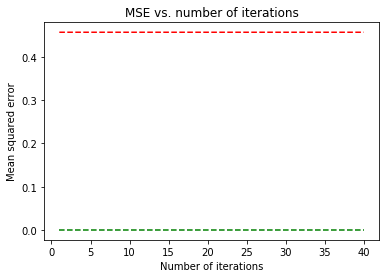

In [63]:
fig, ax = plt.subplots()
ax.plot(iter_nums, test_errors, '--', color = 'r')
ax.plot(iter_nums, vali_errors, '--', color = 'g')

ax.set_ylabel('Mean squared error')
ax.set_xlabel('Number of iterations')
ax.set_title("MSE vs. number of iterations")
plt.show()

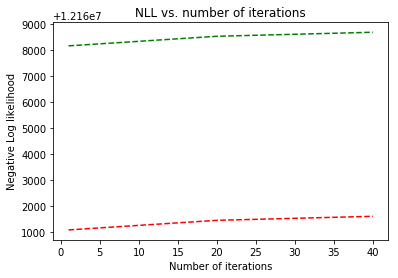

In [64]:
fig, ax = plt.subplots()
ax.plot(iter_nums, test_nlls, '--', color = 'r')
ax.plot(iter_nums, vali_nlls, '--', color = 'g')

ax.set_ylabel('Negative Log likelihood')
ax.set_xlabel('Number of iterations')
ax.set_title('NLL vs. number of iterations')
plt.show()

As number of iterations increases from 1 to 20 to 40, we do not observe much change on error rate, but negative log likelihood increases. These might be resulted from the fact that the change in number of iterations is very small. Due to the running time of this program, we do not choose larger numbers. 

In theory, error rate should drop as number of iterations increases.

# Part 4 (Competition): build your own linear classifier

In [ ]:
# clf = AdaBoostClassifier(SGDClassifier, n_estimators=100)
# SGDClassifier, RidgeClassifierCV

In [46]:
data_test = spark.read.json('/project/cmsc25025/beer_review/unlabeled.json')

In [47]:
data_test.show(2)

+----------+-----+-------+--------------------+------+------+--------------------+---------+-----+-----+
|appearance|aroma|beer_id|           beer_name|brewer|palate|              review|review_id|style|taste|
+----------+-----+-------+--------------------+------+------+--------------------+---------+-----+-----+
|       2.0|  4.0|  65957|John Harvards Fan...|  3084|   2.0|On tap at the Spr...|        4|   33|  4.0|
|       4.0|  5.0|  19708|John Harvards Dr....|  3084|   4.0|From Springfield ...|       12|   60|  7.0|
+----------+-----+-------+--------------------+------+------+--------------------+---------+-----+-----+
only showing top 2 rows



In [48]:
#getting features
row = Row("Sent") 
xRDD = data.rdd.map(lambda x:(x['appearance'],x['aroma'],x['palate'],x['style'], x['taste'])).cache()
yRDD = data.rdd.map(lambda x:get_sent(x['overall'])).map(row).cache()

X_testRDD = data_test.rdd.map(lambda x:(x['appearance'],x['aroma'],x['palate'],x['style'], x['taste'])).cache()

In [49]:
X = xRDD.toDF().toPandas()
y = yRDD.toDF().toPandas()

X_test = X_testRDD.toDF().toPandas()

In [50]:
#initialize classifier
clf = AdaBoostClassifier(SGDClassifier(loss='hinge'),algorithm='SAMME', n_estimators=100)
clf.fit(X,y)
pred = clf.predict(X_test)

/software/python-2.7.12-el7-x86_64/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [51]:
ids = data_test.select('review_id').collect()
pred_dict = {}
for i in range(len(pred)):
    pred_dict[str(ids[i])] = pred[i]  

In [52]:
with open('assn3_prob4_predict.json', 'w') as f:
    json.dump(pred_dict, f)

In [53]:
#spark.stop()